In [11]:
import os
import warnings
warnings.filterwarnings(action='once')
from nilearn import datasets
from nilearn.input_data import NiftiMasker
import numpy as np
# cognitive annotations
import pandas as pd
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Sequence, Any
from deepmeg.preprocessing.transforms import one_hot_encoder, zscore
from deepmeg.data.datasets import EpochsDataset
from deepmeg.models import BaseModel
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchmetrics
from deepmeg.training.callbacks import EarlyStopping, PrintingCallback, L2Reg
from deepmeg.utils.viz import plot_metrics
from functools import partial
from deepmeg.utils.convtools import compute_output_shape, conviter
import torch.nn.init as init
import math
from deepmeg.preprocessing.transforms import one_hot_encoder, one_hot_decoder


def accuracy(predictions, targets):
    """
    Computes the accuracy metric for multiclass tasks with one-hot encoded labels.

    Args:
    - predictions: A PyTorch tensor of shape (batch_size, num_classes) representing the model's predictions.
    - targets: A PyTorch tensor of shape (batch_size, num_classes) representing the true labels in one-hot encoded format.

    Returns:
    - accuracy: A float value representing the accuracy metric.
    """

    # Convert one-hot encoded labels to class indices
    targets = torch.argmax(targets, dim=1)

    # Compute predicted class indices
    _, predicted = torch.max(predictions, dim=1)

    # Compute accuracy
    correct = torch.sum(predicted == targets)
    total = targets.shape[0]
    accuracy = correct / total

    return accuracy

/home/user/Projects/deepmeg/venv/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [1201]:
X, Y = list(), list()
n_samples = 500
sfreq = 200

for i in range(500):
    zeros = np.zeros(sfreq)
    mask0 = zeros.copy()
    mask0[50:100] = 1
    mask0r = mask0.copy()
    mask0r = -(mask0r - 1)
    sample0 = mask0 * np.sin(10*np.arange(sfreq)) + mask0r * np.cos(np.arange(sfreq)) + 2*np.random.random(sfreq)-1
    X.append(sample0)
    Y.append(0)
    mask1 = zeros.copy()
    mask1[50:100] = 1
    mask1r = mask1.copy()
    mask1r = -(mask1r - 1)
    sample1 = mask1 * np.sin(10*(np.arange(sfreq) + 1.5)) + mask1r * np.cos(np.arange(sfreq)) + 2*np.random.random(sfreq)-1
    X.append(sample1)
    Y.append(1)

X = np.array(X)
Y = one_hot_encoder(Y)

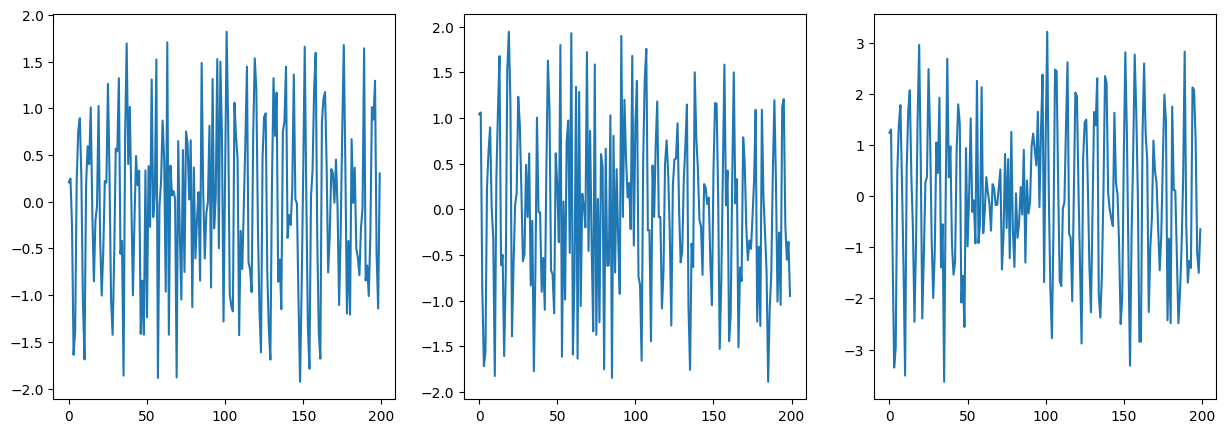

In [1202]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))

ax1.plot(X[0])
ax2.plot(X[1])
ax3.plot(X[0] + X[1])

In [1203]:
dataset = EpochsDataset((X, Y), savepath='../datasets/binary_sel', transform=zscore)
dataset.save('../data/binary_sel.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [1204]:
X, Y = next(iter(DataLoader(test, 2)))

In [1205]:
class TSel(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        kernel_size,
        stride=1,
        padding=0,
        bias=True,
    ):
        super().__init__()
        self.in_features, self.out_features = in_features, out_features
        self.weight = nn.Parameter(torch.empty(self.in_features, self.out_features))
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        if bias:
            self.bias = nn.Parameter(torch.empty(1))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        """Reset the layer parameters.
        Uses the Kaiming initialization method for the weight matrix and a uniform initialization method for the bias vector.
        """
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))

        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)

            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                init.uniform_(self.bias, -bound, bound)


    def forward(self, x):
        convargs = ((x.shape[-1],), (self.kernel_size,), self.padding, self.stride)
        print(compute_output_shape(*convargs))
        
        out =  x @ self.weight + self.bias

        return out

layer = TSel(200, 10, 10, 10)

layer(X).shape

(20,)


torch.Size([2, 10])

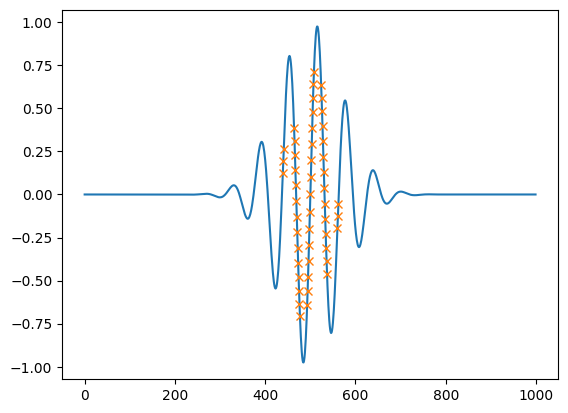

In [1206]:
x = np.arange(1000)
y = -x**2 + 1
phi = 500
y = np.sin(.1*(x-phi))*np.exp(-(x-phi)**2/10000)

dx = x[1] - x[0]
dy = np.diff(y)
dist = np.append(dx, np.sqrt(dx**2 + dy**2))

nodes = dist
# for n in (dist//dx):
#     for _ in range(int(n)):
#         nodes.append(dx/n)

plt.plot(x, y)
# plt.plot(
#     x, nodes, 'x'
#     # np.cumsum(nodes) + x[0], np.zeros_like(nodes), 'x'
# )
# plt.hlines(dist.mean(), x[0], x[-1], 'r', linewidth=.5)
# y[dist < dist.mean()] = np.nan
y[np.argsort(dist)[:-50]] = np.nan
plt.plot(
    x,
    y,
    'x'
    # y[np.argsort(dist)[-100:]]
)


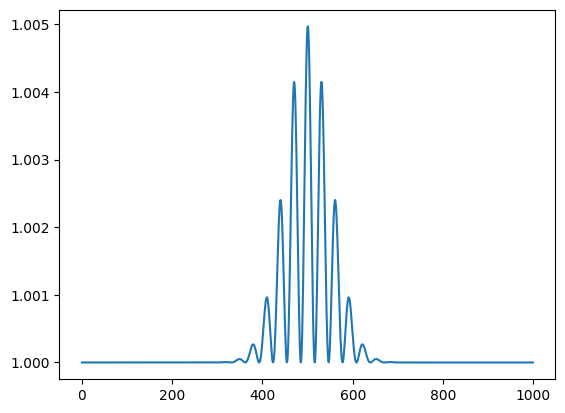

In [1086]:
plt.plot(dist)

In [1208]:
def get_selection(x, n_pooled):
    x = x.copy()
    dx = np.diff(x)
    dist =np.append(1, np.sqrt(1**2 + dx**2))
    x[np.sort(np.argsort(dist)[:-n_pooled])] = np.nan
    return x


class NonLinPool(nn.Module):
    def __init__(
        self,
        n_elems
    ):
        super().__init__()
        self.n_elems = n_elems


    def forward(self, x):
        dx = torch.diff(x)
        dist = torch.cat(
            (torch.ones((x.shape[0], 1)), torch.sqrt(dx**2 + 1)),
            dim=1
        )
        # out_tensor = torch.zeros(x.shape[0], self.n_elems)
        # for n_batch in range(x.shape[0]):
        #     out_tensor[n_batch] = x[n_batch, torch.sort(torch.argsort(dist[n_batch])[-self.n_elems:]).values]
        out_tensor = torch.zeros_like(x[:, :self.n_elems])

        sorted_indices = torch.sort(torch.argsort(dist, dim=1)[:, -self.n_elems:]).values
        out_tensor = x.gather(1, sorted_indices)

        return out_tensor

layer = NonLinPool(100)

x = np.arange(1000)
y = -x**2 + 1
phi = 500
y = torch.tensor(np.expand_dims(np.sin(.1*(x-phi))*np.exp(-(x-phi)**2/100000), 0))


out = layer(y).detach()
out.shape

torch.Size([1, 100])

In [1264]:
class Bias(nn.Module):
    def __init__(
        self,
        n_elems
    ):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(n_elems))
        self.bias = nn.Parameter(torch.empty(n_elems))
        self.reset_parameters()
    def reset_parameters(self) -> None:
        bound = math.sqrt(5)
        init.uniform_(self.weight, -bound, bound)
        init.uniform_(self.bias, -bound, bound)
    def forward(self, x):
        return x * self.weight# + self.bias

In [1277]:
class TinyNet(BaseModel):

    def __init__(
        self,
        n_features: int,
        n_latent: int,
        n_pooled: int,
        n_outputs: int
    ):
        super().__init__()
        self.n_features = n_features
        self.n_latent = n_latent
        self.n_pooled = n_pooled
        self.bias = Bias(n_features)
        self.temp_conv = nn.Conv1d(1, 1, kernel_size=self.n_latent, bias=True, groups=1, padding='same')
        self.fc_layer0 = nn.Linear(self.n_features, self.n_latent)
        self.pool = NonLinPool(n_pooled)
        self.fc_layer = nn.Linear(self.n_pooled, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.temp_conv(torch.unsqueeze(x, 1))
        x = torch.squeeze(x, 1)
        # x = self.fc_layer0(x)
        x = self.bias(x)
        # x = self.pool(x)
        x = x[:, ::10]
        return self.fc_layer(x)

In [1278]:
model = TinyNet(200, 100, 20, 2)

# if you want to define optimizer, do not forget to specify model parameters (e.g., torch.optim.Adam(model.parameters()))
optimizer = torch.optim.Adam

loss = torch.nn.BCEWithLogitsLoss()
metric = accuracy

# in model compilation two callbacks are used: PrintingCallback is used to print training history and EarlyStopping is used to prevent overfitting
model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_val', restore_best_weights=True)
    ]
)

In [1279]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

In [1280]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

Epoch 0:  loss_train:  0.6762   |    accuracy_train:  0.5749   |    loss_val:  0.6602   |    accuracy_val:  0.6144
Epoch 1:  loss_train:  0.6611   |    accuracy_train:  0.6360   |    loss_val:  0.6457   |    accuracy_val:  0.7054
Epoch 2:  loss_train:  0.6458   |    accuracy_train:  0.7259   |    loss_val:  0.6305   |    accuracy_val:  0.7828
Epoch 3:  loss_train:  0.6299   |    accuracy_train:  0.8139   |    loss_val:  0.6143   |    accuracy_val:  0.8431
Epoch 4:  loss_train:  0.6130   |    accuracy_train:  0.8768   |    loss_val:  0.5970   |    accuracy_val:  0.9060
Epoch 5:  loss_train:  0.5951   |    accuracy_train:  0.9275   |    loss_val:  0.5783   |    accuracy_val:  0.9556
Epoch 6:  loss_train:  0.5760   |    accuracy_train:  0.9513   |    loss_val:  0.5583   |    accuracy_val:  0.9833
Epoch 7:  loss_train:  0.5557   |    accuracy_train:  0.9793   |    loss_val:  0.5370   |    accuracy_val:  0.9833
Epoch 8:  loss_train:  0.5341   |    accuracy_train:  0.9843   |    loss_val:  0

KeyboardInterrupt: 

In [1269]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.0020617699716240167
train_accuracy: 1.0
loss: 0.0025798993709031494
accuracy: 1.0


In [1270]:
X, Y = next(iter(DataLoader(test, 10)))

In [1271]:
Y

tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])

In [1272]:
# latent_space = model.temp_conv(torch.unsqueeze(X, 1)).detach().numpy()
latent_space = model.bias(model.temp_conv(torch.unsqueeze(X, 1))).detach().numpy()
# latent_space = model.fc_layer0(X).detach().numpy()
# latent_space = model.fc_layer0(model.temp_conv(torch.unsqueeze(X, 1))).detach().numpy()

In [1273]:
def get_selection(x, n_pooled):
    x = x.copy()
    dx = np.diff(x)
    dist =np.append(1, np.sqrt(1**2 + dx**2))
    x[np.sort(np.argsort(dist)[:-n_pooled])] = np.nan
    return x

In [1274]:
latent_space.shape

(10, 1, 200)

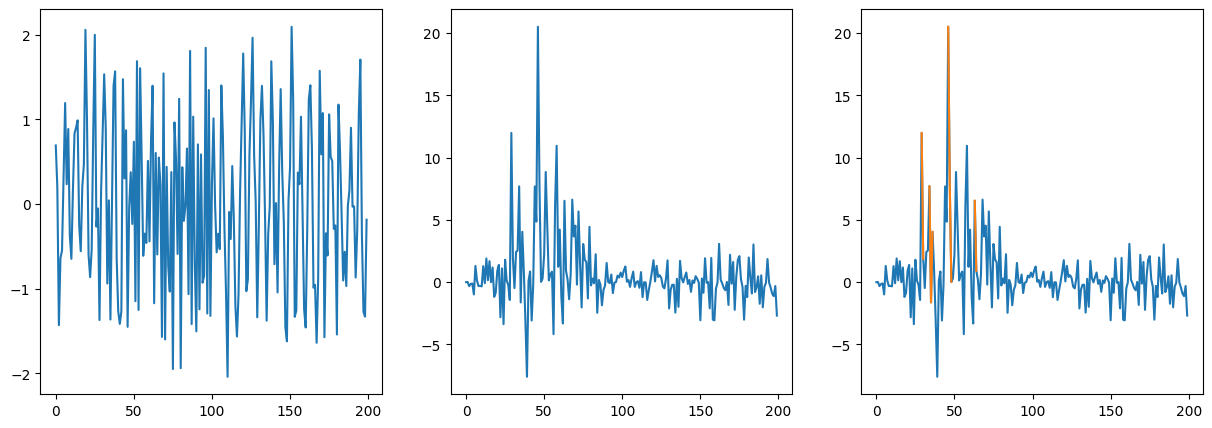

In [1281]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))

ax1.plot(X[0])
ax2.plot(latent_space[0].T)
ax3.plot(latent_space[0].T)
ax3.plot(get_selection(np.squeeze(latent_space[0]), 20))

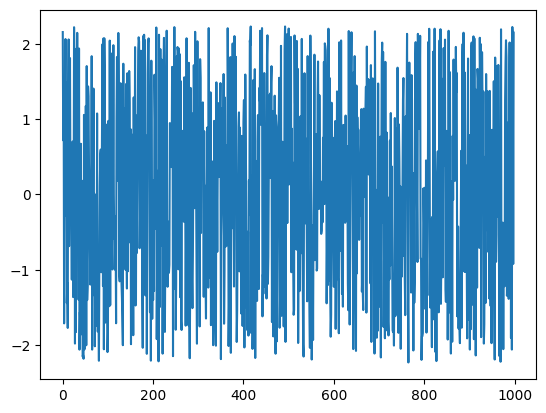

In [1039]:
plt.plot(model.pool.weight.detach())

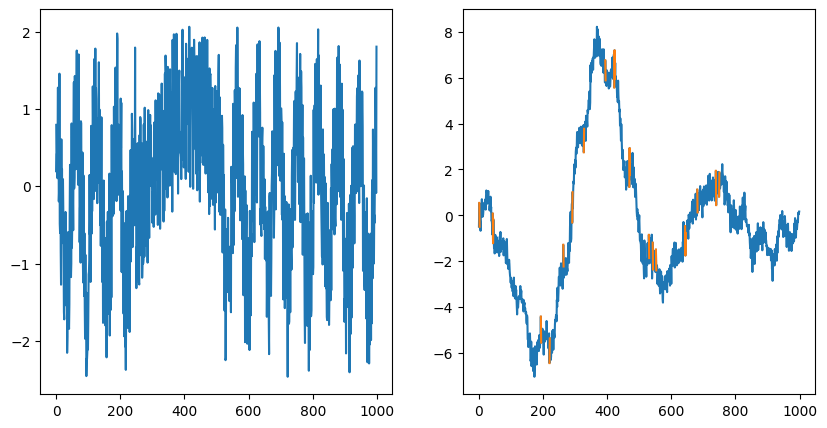

In [865]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
n = -2
ax1.plot(X[n])
ax2.plot(latent_space[n].T)
ax2.plot(get_selection(np.squeeze(latent_space[n]), 100))

### multimodal

In [1288]:
dataset = EpochsDataset.load('../data/multimodal.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [1327]:
class NonLinPool(nn.Module):
    def __init__(
        self,
        n_elems
    ):
        super().__init__()
        self.n_elems = n_elems


    def forward(self, x):
        dx = torch.diff(x)
        # print(torch.ones((x.shape[0], x.shape[1], 1)).shape, torch.sqrt(dx**2 + 1).shape)
        dist = torch.cat(
            (torch.ones((x.shape[0], x.shape[1], 1)), torch.sqrt(dx**2 + 1)), # dt = 1
            dim=-1
        )
        # out_tensor = torch.zeros(x.shape[0], self.n_elems)
        # for n_batch in range(x.shape[0]):
        #     out_tensor[n_batch] = x[n_batch, torch.sort(torch.argsort(dist[n_batch])[-self.n_elems:]).values]
        out_tensor = torch.zeros_like(x[:, :, :self.n_elems])

        # sorted_indices = torch.sort(torch.argsort(dist, dim=1)[:, :, -self.n_elems:]).values
        sorted_indices = torch.sort(torch.argsort(dist, dim=1)[:, :, :self.n_elems]).values
        out_tensor = x.gather(-1, sorted_indices)

        return out_tensor

In [1328]:
class Bias(nn.Module):
    def __init__(
        self,
        n_latent,
        n_times
    ):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(n_latent, n_times))
        self.reset_parameters()
    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
    def forward(self, x):
        return x * self.weight# + self.bias

In [1329]:
class LFCNN(BaseModel):
    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.bias = Bias(n_latent, n_times)
        self.pool = NonLinPool(n_times//self.pool_factor)
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        final_out_features = (n_times//pool_factor)*n_latent #if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        # x = x[:, :, ::self.pool_factor].contiguous()
        x = self.bias(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

In [1331]:
X, Y = next(iter(DataLoader(train, 2)))
X.shape, Y.shape

(torch.Size([2, 204, 301]), torch.Size([2, 8]))

In [1335]:
model(X)

tensor([[-0.0316, -0.0442,  0.0290,  0.0029, -0.0244,  0.0116, -0.0493,  0.0124],
        [-0.0297, -0.0332,  0.0260, -0.0050, -0.0271,  0.0032, -0.0426,  0.0064]],
       grad_fn=<AddmmBackward0>)

In [1336]:
model = LFCNN(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=5, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [1339]:
model.bias.weight.shape

torch.Size([8, 301])

In [1340]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.7236   |    binary_accuracy_train:  0.5094   |    loss_val:  0.7220   |    binary_accuracy_val:  0.5404
Epoch 1:  loss_train:  0.7211   |    binary_accuracy_train:  0.5669   |    loss_val:  0.7195   |    binary_accuracy_val:  0.6304
Epoch 2:  loss_train:  0.7183   |    binary_accuracy_train:  0.6688   |    loss_val:  0.7165   |    binary_accuracy_val:  0.7160
Epoch 3:  loss_train:  0.7149   |    binary_accuracy_train:  0.7397   |    loss_val:  0.7128   |    binary_accuracy_val:  0.7766
Epoch 4:  loss_train:  0.7108   |    binary_accuracy_train:  0.7927   |    loss_val:  0.7083   |    binary_accuracy_val:  0.8076
Epoch 5:  loss_train:  0.7054   |    binary_accuracy_train:  0.8182   |    loss_val:  0.7031   |    binary_accuracy_val:  0.8084
Epoch 6:  loss_train:  0.6988   |    binary_accuracy_train:  0.8268   |    loss_val:  0.6965   |    binary_accuracy_val:  0.7977
Epoch 7:  loss_train:  0.6902   |    binary_accuracy_train:  0.8254   |    loss_val:  0.6880   | 

[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

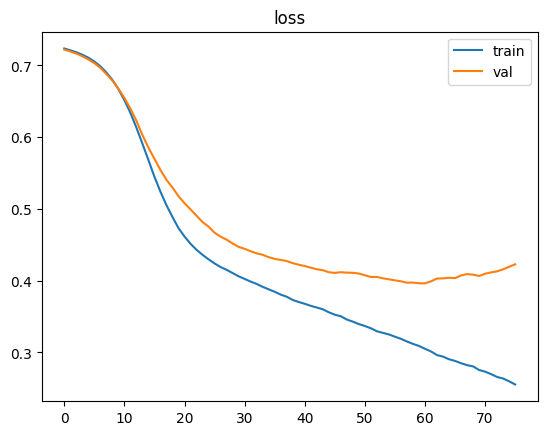

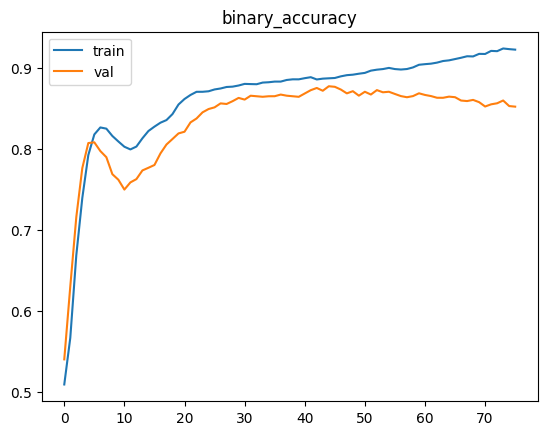

In [1341]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [1342]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.3277251422405243
train_binary_accuracy: 0.8926354971798983
loss: 0.441396258094094
binary_accuracy: 0.863230521028692


In [1343]:
X, Y = next(iter(DataLoader(test, 10)))

In [1345]:
latent = model.bias(model.temp_conv(model.unmixing_layer(X))).detach().numpy()

In [1346]:
def get_selection(x, n_pooled):
    x = x.copy()
    dx = np.diff(x)
    dist =np.append(1, np.sqrt(1**2 + dx**2))
    x[np.sort(np.argsort(dist)[:-n_pooled])] = 0
    # x[np.sort(np.argsort(dist)[n_pooled:])] = 0
    return x

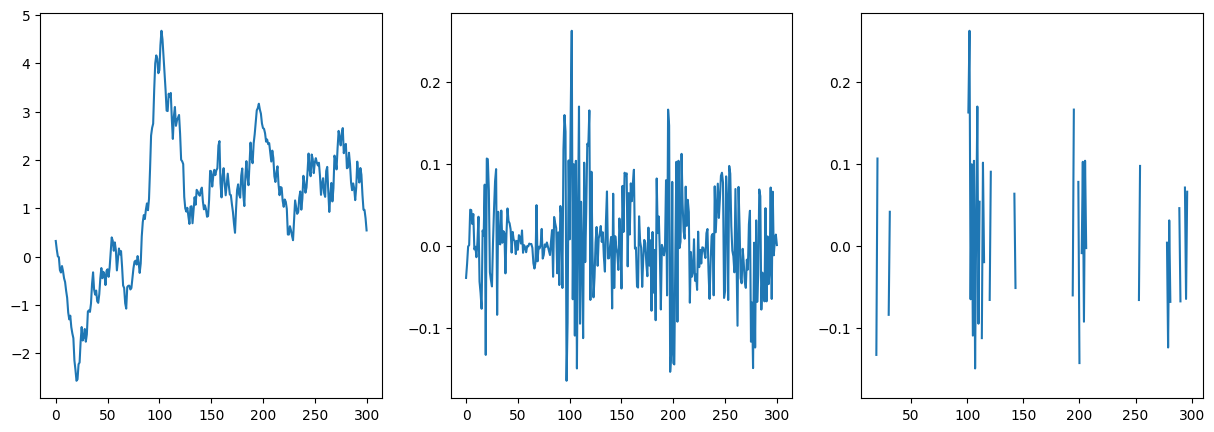

In [1349]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
n = -2
ax1.plot(model.temp_conv(model.unmixing_layer(X)).detach().numpy()[0, 0])
ax2.plot(latent[0, 0])
mask = get_selection(latent[0, 0], 300//5)
mask[mask == 0] = np.nan
ax3.plot(mask)

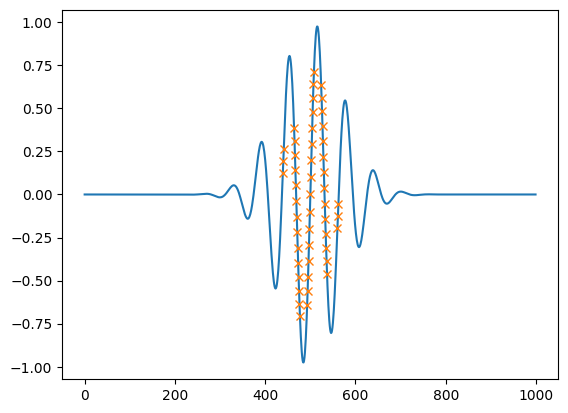

In [1355]:
x = np.arange(1000)
y = -x**2 + 1
phi = 500
y = np.sin(.1*(x-phi))*np.exp(-(x-phi)**2/10000)

dx = x[1] - x[0]
dy = np.diff(y)
dist =np.append(dx, np.sqrt(dx**2 + dy**2))

nodes = dist
# for n in (dist//dx):
#     for _ in range(int(n)):
#         nodes.append(dx/n)

plt.plot(x, y)
# plt.plot(
#     x, nodes, 'x'
#     # np.cumsum(nodes) + x[0], np.zeros_like(nodes), 'x'
# )
# plt.hlines(dist.mean(), x[0], x[-1], 'r', linewidth=.5)
# y[dist < dist.mean()] = np.nan
y[np.argsort(dist)[:-50]] = np.nan
plt.plot(
    x,
    y,
    'x'
    # y[np.argsort(dist)[-100:]]
)


In [3]:
x = np.arange(1000)

phi = 500
y = np.sin(.1*(x-phi))*np.exp(-(x-phi)**2/10000)

y = np.cumsum(np.random.random(1000) - .5)

y = (y - y.mean())/y.std()

dx = x[1] - x[0]
dy = np.diff(y)
# dist =np.append(dx, np.sqrt(dx**2 + dy**2))
# dy_ = np.array([np.sign(dyy)*np.sqrt(d**2 - dx**2) for d, dyy in zip(dist, dy)])
# dy_ = np.array([ddy*dx/.5 for ddy in dy])

# y_ = np.cumsum(dy_)

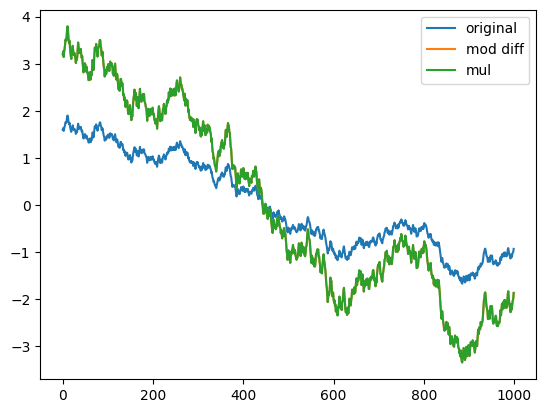

In [27]:
ratio = 2

dy_ = np.array([ddy*ratio for ddy in dy])

dy_ = np.append(y[0]*ratio, dy_)
y_ = np.cumsum(dy_)

plt.plot(y)
plt.plot(y_)
plt.plot(ratio*y)
plt.legend(['original', 'mod diff', 'mul'])


In [149]:
import torch
import torch.nn.functional as F

A = F.pad(torch.ones(10, 10, 10, 10)*0.1, (10, 10, 10, 10, 10, 10))
A = -A + .1

for n in range(len(A)):
    A[n, A.shape[1]//2+int(np.random.randint(1, 10))-5, A.shape[2]//2+int(np.random.randint(1, 10))-5, A.shape[3]//2+int(np.random.randint(1, 10))-5] = 1

In [171]:
A.shape

torch.Size([10, 30, 30, 30])

In [172]:
A = torch.rand((10, 2, 30, 30, 30))

In [176]:
def unravel_index(
    indices: torch.LongTensor,
    shape: tuple[int, ...],
) -> torch.LongTensor:
    r"""Converts flat indices into unraveled coordinates in a target shape.

    This is a `torch` implementation of `numpy.unravel_index`.

    Args:
        indices: A tensor of (flat) indices, (*, N).
        shape: The targeted shape, (D,).

    Returns:
        The unraveled coordinates, (*, N, D).
    """
    coord = []
    for dim in reversed(shape):
        coord.append(indices % dim)
        indices = indices // dim
    coord.reverse()
    return torch.stack(coord, dim=-1)


def get_maximum_indices(X):
    X_f = X.view(X.shape[0], -1)
    indices = torch.argmax(X_f, dim=1)
    return unravel_index(indices, X.shape[1:])

indices = get_maximum_indices(A)
for n in range(len(A)):
    for ch in range(A.shape[1]):
        ind = indices[n, ch]
        print(A.shape, n, ch, ind[0], ind[1], ind[2])
        assert A[n, ch, ind[0], ind[1], ind[2]] == torch.max(A[n, ch]), f'Mistake at {ind}'
print('All good!')

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [169]:
import torch
import torch.nn as nn

class PointSelection3D(nn.Module):
    def __init__(self, n: int):
        super().__init__()
        self.n = n

    def forward(self, x):
        out_tensor = torch.zeros(x.shape[0], 2*self.n, 2*self.n, 2*self.n)
        max_indices = get_maximum_indices(x)
        for n_batch in range(x.shape[0]):
            indices = max_indices[n_batch]
            print(indices)
            out_tensor[n_batch] = x[n_batch, indices[0]-self.n:indices[0]+self.n, indices[1]-self.n:indices[1]+self.n, indices[2]-self.n:indices[2]+self.n]
        return out_tensor


In [168]:
A.shape

torch.Size([10, 30, 30, 30])

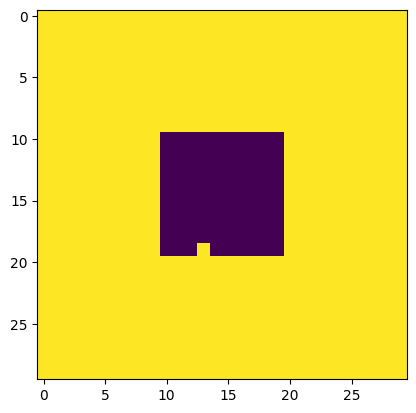

In [150]:
plt.imshow(A[0].mean((2)))

In [170]:
A_ = PointSelection3D(5)(A)

tensor([19, 13, 15])
tensor([13, 12, 14])
tensor([14, 11, 13])
tensor([14, 19, 12])
tensor([13, 12, 13])
tensor([16, 19, 17])
tensor([19, 11, 19])
tensor([15, 13, 18])
tensor([18, 15, 19])
tensor([16, 15, 17])


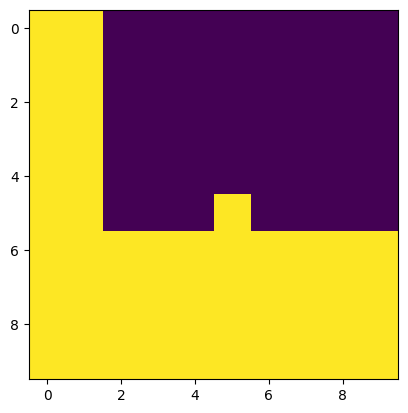

In [167]:
plt.imshow(A_[0].mean((2)))